In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:45 - loss: 1.9067 - STD: 0.0702 - MAE: 0.2078

 17/773 [..............................] - ETA: 2s - loss: 1.3889 - STD: 0.1847 - MAE: 0.1491   

 34/773 [>.............................] - ETA: 2s - loss: 1.3641 - STD: 0.1903 - MAE: 0.1467

 50/773 [>.............................] - ETA: 2s - loss: 1.3489 - STD: 0.1915 - MAE: 0.1459

 66/773 [=>............................] - ETA: 2s - loss: 1.3385 - STD: 0.1919 - MAE: 0.1455

 82/773 [==>...........................] - ETA: 2s - loss: 1.3291 - STD: 0.1920 - MAE: 0.1451

 97/773 [==>...........................] - ETA: 2s - loss: 1.3204 - STD: 0.1923 - MAE: 0.1446

113/773 [===>..........................] - ETA: 2s - loss: 1.3095 - STD: 0.1928 - MAE: 0.1441

130/773 [====>.........................] - ETA: 2s - loss: 1.2967 - STD: 0.1938 - MAE: 0.1433

147/773 [====>.........................] - ETA: 1s - loss: 1.2835 - STD: 0.1944 - MAE: 0.1427

164/773 [=====>........................] - ETA: 1s - loss: 1.2694 - STD: 0.1954 - MAE: 0.1419

180/773 [=====>........................] - ETA: 1s - loss: 1.2566 - STD: 0.1959 - MAE: 0.1413

196/773 [======>.......................] - ETA: 1s - loss: 1.2425 - STD: 0.1968 - MAE: 0.1405

213/773 [=======>......................] - ETA: 1s - loss: 1.2274 - STD: 0.1979 - MAE: 0.1395

221/773 [=======>......................] - ETA: 3s - loss: 1.2208 - STD: 0.1984 - MAE: 0.1391

237/773 [========>.....................] - ETA: 3s - loss: 1.2071 - STD: 0.1994 - MAE: 0.1382

252/773 [========>.....................] - ETA: 2s - loss: 1.1948 - STD: 0.2002 - MAE: 0.1375

268/773 [=========>....................] - ETA: 2s - loss: 1.1813 - STD: 0.2012 - MAE: 0.1366

284/773 [==========>...................] - ETA: 2s - loss: 1.1699 - STD: 0.2021 - MAE: 0.1359

300/773 [==========>...................] - ETA: 2s - loss: 1.1586 - STD: 0.2030 - MAE: 0.1351

315/773 [===========>..................] - ETA: 2s - loss: 1.1476 - STD: 0.2039 - MAE: 0.1343

328/773 [===========>..................] - ETA: 2s - loss: 1.1388 - STD: 0.2047 - MAE: 0.1337

341/773 [============>.................] - ETA: 2s - loss: 1.1293 - STD: 0.2055 - MAE: 0.1329

353/773 [============>.................] - ETA: 2s - loss: 1.1228 - STD: 0.2061 - MAE: 0.1325

367/773 [=============>................] - ETA: 1s - loss: 1.1150 - STD: 0.2068 - MAE: 0.1319

380/773 [=============>................] - ETA: 1s - loss: 1.1075 - STD: 0.2075 - MAE: 0.1313

393/773 [==============>...............] - ETA: 1s - loss: 1.1008 - STD: 0.2081 - MAE: 0.1308

405/773 [==============>...............] - ETA: 1s - loss: 1.0948 - STD: 0.2086 - MAE: 0.1303

417/773 [===============>..............] - ETA: 1s - loss: 1.0891 - STD: 0.2091 - MAE: 0.1299

429/773 [===============>..............] - ETA: 1s - loss: 1.0834 - STD: 0.2096 - MAE: 0.1295

442/773 [================>.............] - ETA: 1s - loss: 1.0776 - STD: 0.2102 - MAE: 0.1290

457/773 [================>.............] - ETA: 1s - loss: 1.0709 - STD: 0.2108 - MAE: 0.1285

474/773 [=================>............] - ETA: 1s - loss: 1.0639 - STD: 0.2115 - MAE: 0.1279

490/773 [==================>...........] - ETA: 1s - loss: 1.0581 - STD: 0.2120 - MAE: 0.1275

506/773 [==================>...........] - ETA: 1s - loss: 1.0523 - STD: 0.2126 - MAE: 0.1271

523/773 [===================>..........] - ETA: 1s - loss: 1.0464 - STD: 0.2131 - MAE: 0.1266

540/773 [===================>..........] - ETA: 1s - loss: 1.0407 - STD: 0.2136 - MAE: 0.1261

557/773 [====================>.........] - ETA: 0s - loss: 1.0359 - STD: 0.2141 - MAE: 0.1257

574/773 [=====================>........] - ETA: 0s - loss: 1.0312 - STD: 0.2146 - MAE: 0.1254

590/773 [=====================>........] - ETA: 0s - loss: 1.0268 - STD: 0.2150 - MAE: 0.1250

607/773 [======================>.......] - ETA: 0s - loss: 1.0230 - STD: 0.2154 - MAE: 0.1247

620/773 [=======================>......] - ETA: 0s - loss: 1.0200 - STD: 0.2157 - MAE: 0.1245

634/773 [=======================>......] - ETA: 0s - loss: 1.0164 - STD: 0.2160 - MAE: 0.1242

649/773 [========================>.....] - ETA: 0s - loss: 1.0131 - STD: 0.2163 - MAE: 0.1239

664/773 [========================>.....] - ETA: 0s - loss: 1.0093 - STD: 0.2167 - MAE: 0.1236

677/773 [=========================>....] - ETA: 0s - loss: 1.0062 - STD: 0.2170 - MAE: 0.1234

692/773 [=========================>....] - ETA: 0s - loss: 1.0024 - STD: 0.2173 - MAE: 0.1230

705/773 [==========================>...] - ETA: 0s - loss: 0.9994 - STD: 0.2176 - MAE: 0.1228

718/773 [==========================>...] - ETA: 0s - loss: 0.9967 - STD: 0.2179 - MAE: 0.1226

731/773 [===========================>..] - ETA: 0s - loss: 0.9937 - STD: 0.2182 - MAE: 0.1223

746/773 [===========================>..] - ETA: 0s - loss: 0.9903 - STD: 0.2185 - MAE: 0.1220

760/773 [============================>.] - ETA: 0s - loss: 0.9873 - STD: 0.2188 - MAE: 0.1218

773/773 [==============================] - 5s 5ms/step - loss: 0.9847 - STD: 0.2190 - MAE: 0.1216 - val_loss: 0.8428 - val_STD: 0.2289 - val_MAE: 0.1091


Epoch 2/10000


  1/773 [..............................] - ETA: 17s - loss: 0.8599 - STD: 0.2304 - MAE: 0.1113

 13/773 [..............................] - ETA: 3s - loss: 0.8390 - STD: 0.2348 - MAE: 0.1088 

 25/773 [..............................] - ETA: 3s - loss: 0.8443 - STD: 0.2331 - MAE: 0.1100

 37/773 [>.............................] - ETA: 3s - loss: 0.8348 - STD: 0.2334 - MAE: 0.1094

 52/773 [=>............................] - ETA: 2s - loss: 0.8353 - STD: 0.2336 - MAE: 0.1093

 66/773 [=>............................] - ETA: 2s - loss: 0.8341 - STD: 0.2339 - MAE: 0.1090

 78/773 [==>...........................] - ETA: 2s - loss: 0.8346 - STD: 0.2337 - MAE: 0.1091

 90/773 [==>...........................] - ETA: 2s - loss: 0.8327 - STD: 0.2338 - MAE: 0.1090

102/773 [==>...........................] - ETA: 2s - loss: 0.8309 - STD: 0.2341 - MAE: 0.1088

115/773 [===>..........................] - ETA: 2s - loss: 0.8295 - STD: 0.2341 - MAE: 0.1087

128/773 [===>..........................] - ETA: 2s - loss: 0.8258 - STD: 0.2344 - MAE: 0.1084

142/773 [====>.........................] - ETA: 2s - loss: 0.8226 - STD: 0.2348 - MAE: 0.1080

154/773 [====>.........................] - ETA: 2s - loss: 0.8219 - STD: 0.2350 - MAE: 0.1079

166/773 [=====>........................] - ETA: 2s - loss: 0.8216 - STD: 0.2350 - MAE: 0.1078

180/773 [=====>........................] - ETA: 2s - loss: 0.8209 - STD: 0.2352 - MAE: 0.1077

197/773 [======>.......................] - ETA: 2s - loss: 0.8208 - STD: 0.2354 - MAE: 0.1076

214/773 [=======>......................] - ETA: 2s - loss: 0.8206 - STD: 0.2354 - MAE: 0.1076

230/773 [=======>......................] - ETA: 2s - loss: 0.8193 - STD: 0.2354 - MAE: 0.1075

246/773 [========>.....................] - ETA: 2s - loss: 0.8186 - STD: 0.2355 - MAE: 0.1074

262/773 [=========>....................] - ETA: 1s - loss: 0.8186 - STD: 0.2355 - MAE: 0.1074

278/773 [=========>....................] - ETA: 1s - loss: 0.8181 - STD: 0.2355 - MAE: 0.1074

295/773 [==========>...................] - ETA: 1s - loss: 0.8169 - STD: 0.2357 - MAE: 0.1073

312/773 [===========>..................] - ETA: 1s - loss: 0.8156 - STD: 0.2357 - MAE: 0.1072

328/773 [===========>..................] - ETA: 1s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1071

344/773 [============>.................] - ETA: 1s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1071

360/773 [============>.................] - ETA: 1s - loss: 0.8124 - STD: 0.2360 - MAE: 0.1069

376/773 [=============>................] - ETA: 1s - loss: 0.8118 - STD: 0.2361 - MAE: 0.1068

392/773 [==============>...............] - ETA: 1s - loss: 0.8113 - STD: 0.2362 - MAE: 0.1068

408/773 [==============>...............] - ETA: 1s - loss: 0.8104 - STD: 0.2363 - MAE: 0.1067

424/773 [===============>..............] - ETA: 1s - loss: 0.8100 - STD: 0.2364 - MAE: 0.1066

440/773 [================>.............] - ETA: 1s - loss: 0.8092 - STD: 0.2365 - MAE: 0.1066

456/773 [================>.............] - ETA: 1s - loss: 0.8083 - STD: 0.2365 - MAE: 0.1065

473/773 [=================>............] - ETA: 1s - loss: 0.8072 - STD: 0.2366 - MAE: 0.1064

489/773 [=================>............] - ETA: 0s - loss: 0.8063 - STD: 0.2367 - MAE: 0.1063

506/773 [==================>...........] - ETA: 0s - loss: 0.8051 - STD: 0.2368 - MAE: 0.1062

521/773 [===================>..........] - ETA: 0s - loss: 0.8042 - STD: 0.2369 - MAE: 0.1061

535/773 [===================>..........] - ETA: 0s - loss: 0.8037 - STD: 0.2370 - MAE: 0.1060

550/773 [====================>.........] - ETA: 0s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1060

564/773 [====================>.........] - ETA: 0s - loss: 0.8022 - STD: 0.2371 - MAE: 0.1059

577/773 [=====================>........] - ETA: 0s - loss: 0.8014 - STD: 0.2372 - MAE: 0.1058

592/773 [=====================>........] - ETA: 0s - loss: 0.8005 - STD: 0.2373 - MAE: 0.1057

607/773 [======================>.......] - ETA: 0s - loss: 0.8000 - STD: 0.2374 - MAE: 0.1057

621/773 [=======================>......] - ETA: 0s - loss: 0.7994 - STD: 0.2374 - MAE: 0.1057

633/773 [=======================>......] - ETA: 0s - loss: 0.7989 - STD: 0.2375 - MAE: 0.1056

646/773 [========================>.....] - ETA: 0s - loss: 0.7985 - STD: 0.2375 - MAE: 0.1056

659/773 [========================>.....] - ETA: 0s - loss: 0.7980 - STD: 0.2376 - MAE: 0.1055

671/773 [=========================>....] - ETA: 0s - loss: 0.7973 - STD: 0.2376 - MAE: 0.1055

685/773 [=========================>....] - ETA: 0s - loss: 0.7970 - STD: 0.2376 - MAE: 0.1054

702/773 [==========================>...] - ETA: 0s - loss: 0.7962 - STD: 0.2377 - MAE: 0.1054

718/773 [==========================>...] - ETA: 0s - loss: 0.7956 - STD: 0.2377 - MAE: 0.1054

733/773 [===========================>..] - ETA: 0s - loss: 0.7949 - STD: 0.2378 - MAE: 0.1053

750/773 [============================>.] - ETA: 0s - loss: 0.7939 - STD: 0.2379 - MAE: 0.1052

766/773 [============================>.] - ETA: 0s - loss: 0.7934 - STD: 0.2380 - MAE: 0.1051

773/773 [==============================] - 3s 4ms/step - loss: 0.7934 - STD: 0.2380 - MAE: 0.1051 - val_loss: 0.8128 - val_STD: 0.2287 - val_MAE: 0.1091


Epoch 3/10000


  1/773 [..............................] - ETA: 19s - loss: 0.7551 - STD: 0.2322 - MAE: 0.1050

 16/773 [..............................] - ETA: 2s - loss: 0.7733 - STD: 0.2404 - MAE: 0.1030 

 33/773 [>.............................] - ETA: 2s - loss: 0.7563 - STD: 0.2412 - MAE: 0.1018

 50/773 [>.............................] - ETA: 2s - loss: 0.7579 - STD: 0.2411 - MAE: 0.1020

 67/773 [=>............................] - ETA: 2s - loss: 0.7592 - STD: 0.2410 - MAE: 0.1021

 85/773 [==>...........................] - ETA: 2s - loss: 0.7609 - STD: 0.2411 - MAE: 0.1022

102/773 [==>...........................] - ETA: 2s - loss: 0.7585 - STD: 0.2414 - MAE: 0.1019

120/773 [===>..........................] - ETA: 1s - loss: 0.7569 - STD: 0.2414 - MAE: 0.1018

136/773 [====>.........................] - ETA: 1s - loss: 0.7555 - STD: 0.2417 - MAE: 0.1016

153/773 [====>.........................] - ETA: 1s - loss: 0.7550 - STD: 0.2417 - MAE: 0.1016

170/773 [=====>........................] - ETA: 1s - loss: 0.7540 - STD: 0.2419 - MAE: 0.1015

187/773 [======>.......................] - ETA: 1s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1014

204/773 [======>.......................] - ETA: 1s - loss: 0.7538 - STD: 0.2420 - MAE: 0.1014

221/773 [=======>......................] - ETA: 1s - loss: 0.7524 - STD: 0.2420 - MAE: 0.1013

238/773 [========>.....................] - ETA: 1s - loss: 0.7521 - STD: 0.2421 - MAE: 0.1012

255/773 [========>.....................] - ETA: 1s - loss: 0.7513 - STD: 0.2421 - MAE: 0.1012

271/773 [=========>....................] - ETA: 1s - loss: 0.7497 - STD: 0.2422 - MAE: 0.1010

287/773 [==========>...................] - ETA: 1s - loss: 0.7496 - STD: 0.2423 - MAE: 0.1010

304/773 [==========>...................] - ETA: 1s - loss: 0.7493 - STD: 0.2423 - MAE: 0.1010

321/773 [===========>..................] - ETA: 1s - loss: 0.7493 - STD: 0.2424 - MAE: 0.1009

339/773 [============>.................] - ETA: 1s - loss: 0.7498 - STD: 0.2424 - MAE: 0.1010

356/773 [============>.................] - ETA: 1s - loss: 0.7493 - STD: 0.2423 - MAE: 0.1010

373/773 [=============>................] - ETA: 1s - loss: 0.7488 - STD: 0.2424 - MAE: 0.1010

391/773 [==============>...............] - ETA: 1s - loss: 0.7478 - STD: 0.2425 - MAE: 0.1008

409/773 [==============>...............] - ETA: 1s - loss: 0.7470 - STD: 0.2426 - MAE: 0.1008

426/773 [===============>..............] - ETA: 1s - loss: 0.7466 - STD: 0.2426 - MAE: 0.1007

444/773 [================>.............] - ETA: 0s - loss: 0.7465 - STD: 0.2426 - MAE: 0.1007

461/773 [================>.............] - ETA: 0s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1008

477/773 [=================>............] - ETA: 0s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1008

494/773 [==================>...........] - ETA: 0s - loss: 0.7465 - STD: 0.2426 - MAE: 0.1007

512/773 [==================>...........] - ETA: 0s - loss: 0.7464 - STD: 0.2426 - MAE: 0.1007

530/773 [===================>..........] - ETA: 0s - loss: 0.7457 - STD: 0.2427 - MAE: 0.1007

548/773 [====================>.........] - ETA: 0s - loss: 0.7454 - STD: 0.2427 - MAE: 0.1006

565/773 [====================>.........] - ETA: 0s - loss: 0.7446 - STD: 0.2428 - MAE: 0.1006

582/773 [=====================>........] - ETA: 0s - loss: 0.7441 - STD: 0.2428 - MAE: 0.1005

599/773 [======================>.......] - ETA: 0s - loss: 0.7434 - STD: 0.2429 - MAE: 0.1004

616/773 [======================>.......] - ETA: 0s - loss: 0.7433 - STD: 0.2429 - MAE: 0.1004

633/773 [=======================>......] - ETA: 0s - loss: 0.7428 - STD: 0.2430 - MAE: 0.1004

650/773 [========================>.....] - ETA: 0s - loss: 0.7423 - STD: 0.2430 - MAE: 0.1003

666/773 [========================>.....] - ETA: 0s - loss: 0.7421 - STD: 0.2431 - MAE: 0.1003

683/773 [=========================>....] - ETA: 0s - loss: 0.7417 - STD: 0.2431 - MAE: 0.1003

700/773 [==========================>...] - ETA: 0s - loss: 0.7413 - STD: 0.2431 - MAE: 0.1002

716/773 [==========================>...] - ETA: 0s - loss: 0.7412 - STD: 0.2431 - MAE: 0.1002

732/773 [===========================>..] - ETA: 0s - loss: 0.7409 - STD: 0.2432 - MAE: 0.1002

750/773 [============================>.] - ETA: 0s - loss: 0.7407 - STD: 0.2432 - MAE: 0.1002

767/773 [============================>.] - ETA: 0s - loss: 0.7404 - STD: 0.2432 - MAE: 0.1001

773/773 [==============================] - 3s 3ms/step - loss: 0.7403 - STD: 0.2432 - MAE: 0.1001 - val_loss: 0.7468 - val_STD: 0.2430 - val_MAE: 0.0988


Epoch 4/10000


  1/773 [..............................] - ETA: 12s - loss: 0.7155 - STD: 0.2444 - MAE: 0.0978

 17/773 [..............................] - ETA: 2s - loss: 0.7166 - STD: 0.2447 - MAE: 0.0982 

 34/773 [>.............................] - ETA: 2s - loss: 0.7199 - STD: 0.2448 - MAE: 0.0984

 51/773 [>.............................] - ETA: 2s - loss: 0.7241 - STD: 0.2445 - MAE: 0.0988

 69/773 [=>............................] - ETA: 2s - loss: 0.7258 - STD: 0.2448 - MAE: 0.0987

 86/773 [==>...........................] - ETA: 2s - loss: 0.7232 - STD: 0.2449 - MAE: 0.0985

102/773 [==>...........................] - ETA: 2s - loss: 0.7199 - STD: 0.2451 - MAE: 0.0982

118/773 [===>..........................] - ETA: 2s - loss: 0.7262 - STD: 0.2451 - MAE: 0.0985

134/773 [====>.........................] - ETA: 1s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0986

150/773 [====>.........................] - ETA: 1s - loss: 0.7249 - STD: 0.2450 - MAE: 0.0985

167/773 [=====>........................] - ETA: 1s - loss: 0.7227 - STD: 0.2451 - MAE: 0.0983

184/773 [======>.......................] - ETA: 1s - loss: 0.7219 - STD: 0.2453 - MAE: 0.0982

201/773 [======>.......................] - ETA: 1s - loss: 0.7216 - STD: 0.2453 - MAE: 0.0982

219/773 [=======>......................] - ETA: 1s - loss: 0.7224 - STD: 0.2453 - MAE: 0.0983

237/773 [========>.....................] - ETA: 1s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0983

254/773 [========>.....................] - ETA: 1s - loss: 0.7233 - STD: 0.2452 - MAE: 0.0984

271/773 [=========>....................] - ETA: 1s - loss: 0.7232 - STD: 0.2452 - MAE: 0.0984

286/773 [==========>...................] - ETA: 1s - loss: 0.7230 - STD: 0.2451 - MAE: 0.0984

298/773 [==========>...................] - ETA: 1s - loss: 0.7222 - STD: 0.2452 - MAE: 0.0983

310/773 [===========>..................] - ETA: 1s - loss: 0.7212 - STD: 0.2453 - MAE: 0.0982

322/773 [===========>..................] - ETA: 1s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0981

334/773 [===========>..................] - ETA: 1s - loss: 0.7203 - STD: 0.2454 - MAE: 0.0981

347/773 [============>.................] - ETA: 1s - loss: 0.7198 - STD: 0.2454 - MAE: 0.0981

360/773 [============>.................] - ETA: 1s - loss: 0.7192 - STD: 0.2455 - MAE: 0.0980

376/773 [=============>................] - ETA: 1s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0980

390/773 [==============>...............] - ETA: 1s - loss: 0.7183 - STD: 0.2455 - MAE: 0.0979

405/773 [==============>...............] - ETA: 1s - loss: 0.7178 - STD: 0.2456 - MAE: 0.0979

419/773 [===============>..............] - ETA: 1s - loss: 0.7175 - STD: 0.2456 - MAE: 0.0979

433/773 [===============>..............] - ETA: 1s - loss: 0.7178 - STD: 0.2456 - MAE: 0.0979

446/773 [================>.............] - ETA: 1s - loss: 0.7183 - STD: 0.2456 - MAE: 0.0979

458/773 [================>.............] - ETA: 1s - loss: 0.7182 - STD: 0.2456 - MAE: 0.0979

470/773 [=================>............] - ETA: 1s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0978

484/773 [=================>............] - ETA: 0s - loss: 0.7176 - STD: 0.2457 - MAE: 0.0978

497/773 [==================>...........] - ETA: 0s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0978

512/773 [==================>...........] - ETA: 0s - loss: 0.7170 - STD: 0.2457 - MAE: 0.0978

530/773 [===================>..........] - ETA: 0s - loss: 0.7164 - STD: 0.2458 - MAE: 0.0977

546/773 [====================>.........] - ETA: 0s - loss: 0.7166 - STD: 0.2458 - MAE: 0.0977

563/773 [====================>.........] - ETA: 0s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0977

580/773 [=====================>........] - ETA: 0s - loss: 0.7163 - STD: 0.2458 - MAE: 0.0977

597/773 [======================>.......] - ETA: 0s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0976

614/773 [======================>.......] - ETA: 0s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0976

630/773 [=======================>......] - ETA: 0s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0976

646/773 [========================>.....] - ETA: 0s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0975

662/773 [========================>.....] - ETA: 0s - loss: 0.7143 - STD: 0.2460 - MAE: 0.0975

678/773 [=========================>....] - ETA: 0s - loss: 0.7140 - STD: 0.2461 - MAE: 0.0974

694/773 [=========================>....] - ETA: 0s - loss: 0.7139 - STD: 0.2461 - MAE: 0.0974

709/773 [==========================>...] - ETA: 0s - loss: 0.7136 - STD: 0.2461 - MAE: 0.0974

724/773 [===========================>..] - ETA: 0s - loss: 0.7133 - STD: 0.2461 - MAE: 0.0974

738/773 [===========================>..] - ETA: 0s - loss: 0.7130 - STD: 0.2462 - MAE: 0.0973

751/773 [============================>.] - ETA: 0s - loss: 0.7128 - STD: 0.2462 - MAE: 0.0973

763/773 [============================>.] - ETA: 0s - loss: 0.7123 - STD: 0.2462 - MAE: 0.0973

773/773 [==============================] - 3s 4ms/step - loss: 0.7122 - STD: 0.2462 - MAE: 0.0973 - val_loss: 0.7449 - val_STD: 0.2418 - val_MAE: 0.0988


Epoch 5/10000


  1/773 [..............................] - ETA: 15s - loss: 0.6661 - STD: 0.2444 - MAE: 0.0950

 15/773 [..............................] - ETA: 2s - loss: 0.6951 - STD: 0.2479 - MAE: 0.0953 

 32/773 [>.............................] - ETA: 2s - loss: 0.6957 - STD: 0.2475 - MAE: 0.0957

 49/773 [>.............................] - ETA: 2s - loss: 0.6968 - STD: 0.2476 - MAE: 0.0958

 66/773 [=>............................] - ETA: 2s - loss: 0.6987 - STD: 0.2474 - MAE: 0.0960

 81/773 [==>...........................] - ETA: 2s - loss: 0.6987 - STD: 0.2473 - MAE: 0.0961

 98/773 [==>...........................] - ETA: 2s - loss: 0.6982 - STD: 0.2475 - MAE: 0.0960

113/773 [===>..........................] - ETA: 2s - loss: 0.6985 - STD: 0.2475 - MAE: 0.0960

128/773 [===>..........................] - ETA: 2s - loss: 0.6979 - STD: 0.2476 - MAE: 0.0959

144/773 [====>.........................] - ETA: 2s - loss: 0.6980 - STD: 0.2475 - MAE: 0.0959

157/773 [=====>........................] - ETA: 2s - loss: 0.6963 - STD: 0.2476 - MAE: 0.0958

171/773 [=====>........................] - ETA: 2s - loss: 0.6960 - STD: 0.2477 - MAE: 0.0957

187/773 [======>.......................] - ETA: 1s - loss: 0.6955 - STD: 0.2478 - MAE: 0.0957

203/773 [======>.......................] - ETA: 1s - loss: 0.6961 - STD: 0.2479 - MAE: 0.0957

219/773 [=======>......................] - ETA: 1s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0956

231/773 [=======>......................] - ETA: 1s - loss: 0.6950 - STD: 0.2479 - MAE: 0.0956

244/773 [========>.....................] - ETA: 1s - loss: 0.6943 - STD: 0.2479 - MAE: 0.0955

260/773 [=========>....................] - ETA: 1s - loss: 0.6938 - STD: 0.2480 - MAE: 0.0954

276/773 [=========>....................] - ETA: 1s - loss: 0.6931 - STD: 0.2480 - MAE: 0.0954

292/773 [==========>...................] - ETA: 1s - loss: 0.6922 - STD: 0.2481 - MAE: 0.0953

309/773 [==========>...................] - ETA: 1s - loss: 0.6911 - STD: 0.2482 - MAE: 0.0952

326/773 [===========>..................] - ETA: 1s - loss: 0.6908 - STD: 0.2483 - MAE: 0.0951

343/773 [============>.................] - ETA: 1s - loss: 0.6914 - STD: 0.2484 - MAE: 0.0951

360/773 [============>.................] - ETA: 1s - loss: 0.6915 - STD: 0.2484 - MAE: 0.0951

377/773 [=============>................] - ETA: 1s - loss: 0.6912 - STD: 0.2484 - MAE: 0.0951

394/773 [==============>...............] - ETA: 1s - loss: 0.6912 - STD: 0.2484 - MAE: 0.0951

411/773 [==============>...............] - ETA: 1s - loss: 0.6915 - STD: 0.2483 - MAE: 0.0952

428/773 [===============>..............] - ETA: 1s - loss: 0.6919 - STD: 0.2483 - MAE: 0.0952

445/773 [================>.............] - ETA: 1s - loss: 0.6914 - STD: 0.2483 - MAE: 0.0952

462/773 [================>.............] - ETA: 1s - loss: 0.6905 - STD: 0.2484 - MAE: 0.0951

479/773 [=================>............] - ETA: 0s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0951

496/773 [==================>...........] - ETA: 0s - loss: 0.6906 - STD: 0.2484 - MAE: 0.0951

512/773 [==================>...........] - ETA: 0s - loss: 0.6903 - STD: 0.2484 - MAE: 0.0951

529/773 [===================>..........] - ETA: 0s - loss: 0.6904 - STD: 0.2484 - MAE: 0.0951

546/773 [====================>.........] - ETA: 0s - loss: 0.6901 - STD: 0.2484 - MAE: 0.0950

564/773 [====================>.........] - ETA: 0s - loss: 0.6898 - STD: 0.2485 - MAE: 0.0950

580/773 [=====================>........] - ETA: 0s - loss: 0.6895 - STD: 0.2485 - MAE: 0.0950

597/773 [======================>.......] - ETA: 0s - loss: 0.6898 - STD: 0.2485 - MAE: 0.0950

613/773 [======================>.......] - ETA: 0s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0950

626/773 [=======================>......] - ETA: 0s - loss: 0.6896 - STD: 0.2485 - MAE: 0.0950

638/773 [=======================>......] - ETA: 0s - loss: 0.6896 - STD: 0.2485 - MAE: 0.0950

652/773 [========================>.....] - ETA: 0s - loss: 0.6891 - STD: 0.2486 - MAE: 0.0949

666/773 [========================>.....] - ETA: 0s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0949

683/773 [=========================>....] - ETA: 0s - loss: 0.6886 - STD: 0.2486 - MAE: 0.0949

701/773 [==========================>...] - ETA: 0s - loss: 0.6885 - STD: 0.2486 - MAE: 0.0949

718/773 [==========================>...] - ETA: 0s - loss: 0.6882 - STD: 0.2487 - MAE: 0.0948

734/773 [===========================>..] - ETA: 0s - loss: 0.6883 - STD: 0.2487 - MAE: 0.0948

749/773 [============================>.] - ETA: 0s - loss: 0.6878 - STD: 0.2487 - MAE: 0.0948

762/773 [============================>.] - ETA: 0s - loss: 0.6876 - STD: 0.2487 - MAE: 0.0948

773/773 [==============================] - 3s 4ms/step - loss: 0.6872 - STD: 0.2488 - MAE: 0.0947 - val_loss: 0.7668 - val_STD: 0.2427 - val_MAE: 0.1003


Epoch 6/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6943 - STD: 0.2436 - MAE: 0.0977

 16/773 [..............................] - ETA: 2s - loss: 0.6803 - STD: 0.2498 - MAE: 0.0938 

 29/773 [>.............................] - ETA: 2s - loss: 0.6740 - STD: 0.2498 - MAE: 0.0934

 44/773 [>.............................] - ETA: 2s - loss: 0.6754 - STD: 0.2499 - MAE: 0.0935

 57/773 [=>............................] - ETA: 2s - loss: 0.6770 - STD: 0.2496 - MAE: 0.0937

 73/773 [=>............................] - ETA: 2s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0933

 91/773 [==>...........................] - ETA: 2s - loss: 0.6713 - STD: 0.2503 - MAE: 0.0930

109/773 [===>..........................] - ETA: 2s - loss: 0.6719 - STD: 0.2501 - MAE: 0.0932

124/773 [===>..........................] - ETA: 2s - loss: 0.6720 - STD: 0.2502 - MAE: 0.0932

139/773 [====>.........................] - ETA: 2s - loss: 0.6717 - STD: 0.2502 - MAE: 0.0932

157/773 [=====>........................] - ETA: 2s - loss: 0.6722 - STD: 0.2502 - MAE: 0.0932

174/773 [=====>........................] - ETA: 1s - loss: 0.6739 - STD: 0.2501 - MAE: 0.0934

191/773 [======>.......................] - ETA: 1s - loss: 0.6738 - STD: 0.2501 - MAE: 0.0934

209/773 [=======>......................] - ETA: 1s - loss: 0.6735 - STD: 0.2501 - MAE: 0.0933

227/773 [=======>......................] - ETA: 1s - loss: 0.6738 - STD: 0.2502 - MAE: 0.0933

244/773 [========>.....................] - ETA: 1s - loss: 0.6744 - STD: 0.2502 - MAE: 0.0933

261/773 [=========>....................] - ETA: 1s - loss: 0.6748 - STD: 0.2502 - MAE: 0.0934

278/773 [=========>....................] - ETA: 1s - loss: 0.6750 - STD: 0.2501 - MAE: 0.0934

295/773 [==========>...................] - ETA: 1s - loss: 0.6737 - STD: 0.2502 - MAE: 0.0933

312/773 [===========>..................] - ETA: 1s - loss: 0.6737 - STD: 0.2503 - MAE: 0.0932

330/773 [===========>..................] - ETA: 1s - loss: 0.6740 - STD: 0.2502 - MAE: 0.0933

348/773 [============>.................] - ETA: 1s - loss: 0.6735 - STD: 0.2501 - MAE: 0.0933

365/773 [=============>................] - ETA: 1s - loss: 0.6730 - STD: 0.2502 - MAE: 0.0933

382/773 [=============>................] - ETA: 1s - loss: 0.6730 - STD: 0.2502 - MAE: 0.0932

400/773 [==============>...............] - ETA: 1s - loss: 0.6720 - STD: 0.2503 - MAE: 0.0931

418/773 [===============>..............] - ETA: 1s - loss: 0.6721 - STD: 0.2503 - MAE: 0.0931

436/773 [===============>..............] - ETA: 1s - loss: 0.6721 - STD: 0.2504 - MAE: 0.0931

454/773 [================>.............] - ETA: 0s - loss: 0.6723 - STD: 0.2503 - MAE: 0.0931

471/773 [=================>............] - ETA: 0s - loss: 0.6721 - STD: 0.2503 - MAE: 0.0932

486/773 [=================>............] - ETA: 0s - loss: 0.6718 - STD: 0.2503 - MAE: 0.0931

503/773 [==================>...........] - ETA: 0s - loss: 0.6713 - STD: 0.2503 - MAE: 0.0931

521/773 [===================>..........] - ETA: 0s - loss: 0.6707 - STD: 0.2504 - MAE: 0.0930

539/773 [===================>..........] - ETA: 0s - loss: 0.6706 - STD: 0.2505 - MAE: 0.0930

557/773 [====================>.........] - ETA: 0s - loss: 0.6706 - STD: 0.2505 - MAE: 0.0930

575/773 [=====================>........] - ETA: 0s - loss: 0.6704 - STD: 0.2505 - MAE: 0.0930

593/773 [======================>.......] - ETA: 0s - loss: 0.6704 - STD: 0.2505 - MAE: 0.0930

611/773 [======================>.......] - ETA: 0s - loss: 0.6702 - STD: 0.2505 - MAE: 0.0930

628/773 [=======================>......] - ETA: 0s - loss: 0.6699 - STD: 0.2505 - MAE: 0.0929

644/773 [=======================>......] - ETA: 0s - loss: 0.6695 - STD: 0.2506 - MAE: 0.0929

660/773 [========================>.....] - ETA: 0s - loss: 0.6690 - STD: 0.2506 - MAE: 0.0929

677/773 [=========================>....] - ETA: 0s - loss: 0.6683 - STD: 0.2506 - MAE: 0.0928

694/773 [=========================>....] - ETA: 0s - loss: 0.6680 - STD: 0.2507 - MAE: 0.0927

711/773 [==========================>...] - ETA: 0s - loss: 0.6679 - STD: 0.2507 - MAE: 0.0927

729/773 [===========================>..] - ETA: 0s - loss: 0.6679 - STD: 0.2508 - MAE: 0.0927

747/773 [===========================>..] - ETA: 0s - loss: 0.6676 - STD: 0.2508 - MAE: 0.0927

762/773 [============================>.] - ETA: 0s - loss: 0.6675 - STD: 0.2508 - MAE: 0.0927

773/773 [==============================] - 3s 3ms/step - loss: 0.6675 - STD: 0.2508 - MAE: 0.0926 - val_loss: 0.7421 - val_STD: 0.2493 - val_MAE: 0.0958


Epoch 7/10000


  1/773 [..............................] - ETA: 15s - loss: 0.6416 - STD: 0.2569 - MAE: 0.0881

 17/773 [..............................] - ETA: 2s - loss: 0.6566 - STD: 0.2520 - MAE: 0.0915 

 34/773 [>.............................] - ETA: 2s - loss: 0.6608 - STD: 0.2516 - MAE: 0.0919

 52/773 [=>............................] - ETA: 2s - loss: 0.6611 - STD: 0.2517 - MAE: 0.0918

 69/773 [=>............................] - ETA: 2s - loss: 0.6581 - STD: 0.2518 - MAE: 0.0916

 85/773 [==>...........................] - ETA: 2s - loss: 0.6582 - STD: 0.2516 - MAE: 0.0918

102/773 [==>...........................] - ETA: 2s - loss: 0.6588 - STD: 0.2515 - MAE: 0.0918

119/773 [===>..........................] - ETA: 2s - loss: 0.6593 - STD: 0.2514 - MAE: 0.0920

136/773 [====>.........................] - ETA: 1s - loss: 0.6593 - STD: 0.2514 - MAE: 0.0919

152/773 [====>.........................] - ETA: 1s - loss: 0.6588 - STD: 0.2517 - MAE: 0.0917

168/773 [=====>........................] - ETA: 1s - loss: 0.6577 - STD: 0.2516 - MAE: 0.0917

184/773 [======>.......................] - ETA: 1s - loss: 0.6556 - STD: 0.2518 - MAE: 0.0915

201/773 [======>.......................] - ETA: 1s - loss: 0.6548 - STD: 0.2518 - MAE: 0.0914

217/773 [=======>......................] - ETA: 1s - loss: 0.6542 - STD: 0.2519 - MAE: 0.0914

235/773 [========>.....................] - ETA: 1s - loss: 0.6548 - STD: 0.2519 - MAE: 0.0914

251/773 [========>.....................] - ETA: 1s - loss: 0.6545 - STD: 0.2520 - MAE: 0.0914

268/773 [=========>....................] - ETA: 1s - loss: 0.6541 - STD: 0.2520 - MAE: 0.0914

284/773 [==========>...................] - ETA: 1s - loss: 0.6534 - STD: 0.2520 - MAE: 0.0913

300/773 [==========>...................] - ETA: 1s - loss: 0.6543 - STD: 0.2521 - MAE: 0.0913

316/773 [===========>..................] - ETA: 1s - loss: 0.6541 - STD: 0.2521 - MAE: 0.0912

332/773 [===========>..................] - ETA: 1s - loss: 0.6537 - STD: 0.2521 - MAE: 0.0912

349/773 [============>.................] - ETA: 1s - loss: 0.6528 - STD: 0.2522 - MAE: 0.0912

366/773 [=============>................] - ETA: 1s - loss: 0.6519 - STD: 0.2522 - MAE: 0.0911

381/773 [=============>................] - ETA: 1s - loss: 0.6518 - STD: 0.2523 - MAE: 0.0910

397/773 [==============>...............] - ETA: 1s - loss: 0.6518 - STD: 0.2523 - MAE: 0.0910

413/773 [===============>..............] - ETA: 1s - loss: 0.6510 - STD: 0.2524 - MAE: 0.0909

429/773 [===============>..............] - ETA: 1s - loss: 0.6502 - STD: 0.2525 - MAE: 0.0908

446/773 [================>.............] - ETA: 1s - loss: 0.6501 - STD: 0.2525 - MAE: 0.0908

462/773 [================>.............] - ETA: 0s - loss: 0.6495 - STD: 0.2526 - MAE: 0.0908

478/773 [=================>............] - ETA: 0s - loss: 0.6495 - STD: 0.2526 - MAE: 0.0907

494/773 [==================>...........] - ETA: 0s - loss: 0.6503 - STD: 0.2526 - MAE: 0.0908

510/773 [==================>...........] - ETA: 0s - loss: 0.6501 - STD: 0.2526 - MAE: 0.0908

526/773 [===================>..........] - ETA: 0s - loss: 0.6494 - STD: 0.2526 - MAE: 0.0907

542/773 [====================>.........] - ETA: 0s - loss: 0.6497 - STD: 0.2526 - MAE: 0.0907

559/773 [====================>.........] - ETA: 0s - loss: 0.6495 - STD: 0.2526 - MAE: 0.0907

576/773 [=====================>........] - ETA: 0s - loss: 0.6495 - STD: 0.2526 - MAE: 0.0907

592/773 [=====================>........] - ETA: 0s - loss: 0.6491 - STD: 0.2527 - MAE: 0.0907

609/773 [======================>.......] - ETA: 0s - loss: 0.6487 - STD: 0.2527 - MAE: 0.0906

625/773 [=======================>......] - ETA: 0s - loss: 0.6482 - STD: 0.2527 - MAE: 0.0906

641/773 [=======================>......] - ETA: 0s - loss: 0.6481 - STD: 0.2528 - MAE: 0.0906

657/773 [========================>.....] - ETA: 0s - loss: 0.6480 - STD: 0.2528 - MAE: 0.0905

673/773 [=========================>....] - ETA: 0s - loss: 0.6477 - STD: 0.2529 - MAE: 0.0905

688/773 [=========================>....] - ETA: 0s - loss: 0.6473 - STD: 0.2529 - MAE: 0.0905

704/773 [==========================>...] - ETA: 0s - loss: 0.6469 - STD: 0.2529 - MAE: 0.0905

720/773 [==========================>...] - ETA: 0s - loss: 0.6467 - STD: 0.2529 - MAE: 0.0904

737/773 [===========================>..] - ETA: 0s - loss: 0.6462 - STD: 0.2529 - MAE: 0.0904

753/773 [============================>.] - ETA: 0s - loss: 0.6462 - STD: 0.2530 - MAE: 0.0904

770/773 [============================>.] - ETA: 0s - loss: 0.6461 - STD: 0.2530 - MAE: 0.0903

773/773 [==============================] - 3s 3ms/step - loss: 0.6462 - STD: 0.2530 - MAE: 0.0904 - val_loss: 0.7763 - val_STD: 0.2591 - val_MAE: 0.0921


Epoch 8/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6434 - STD: 0.2615 - MAE: 0.0865

 16/773 [..............................] - ETA: 2s - loss: 0.6370 - STD: 0.2532 - MAE: 0.0897 

 31/773 [>.............................] - ETA: 2s - loss: 0.6355 - STD: 0.2535 - MAE: 0.0894

 46/773 [>.............................] - ETA: 2s - loss: 0.6357 - STD: 0.2541 - MAE: 0.0891

 63/773 [=>............................] - ETA: 2s - loss: 0.6351 - STD: 0.2540 - MAE: 0.0892

 78/773 [==>...........................] - ETA: 2s - loss: 0.6349 - STD: 0.2540 - MAE: 0.0892

 92/773 [==>...........................] - ETA: 2s - loss: 0.6347 - STD: 0.2540 - MAE: 0.0892

104/773 [===>..........................] - ETA: 2s - loss: 0.6351 - STD: 0.2539 - MAE: 0.0893

116/773 [===>..........................] - ETA: 2s - loss: 0.6354 - STD: 0.2541 - MAE: 0.0892

128/773 [===>..........................] - ETA: 2s - loss: 0.6351 - STD: 0.2541 - MAE: 0.0892

140/773 [====>.........................] - ETA: 2s - loss: 0.6349 - STD: 0.2542 - MAE: 0.0891

155/773 [=====>........................] - ETA: 2s - loss: 0.6356 - STD: 0.2540 - MAE: 0.0893

168/773 [=====>........................] - ETA: 2s - loss: 0.6350 - STD: 0.2541 - MAE: 0.0892

180/773 [=====>........................] - ETA: 2s - loss: 0.6341 - STD: 0.2541 - MAE: 0.0891

192/773 [======>.......................] - ETA: 2s - loss: 0.6337 - STD: 0.2543 - MAE: 0.0890

207/773 [=======>......................] - ETA: 2s - loss: 0.6331 - STD: 0.2543 - MAE: 0.0890

220/773 [=======>......................] - ETA: 2s - loss: 0.6323 - STD: 0.2544 - MAE: 0.0889

232/773 [========>.....................] - ETA: 2s - loss: 0.6326 - STD: 0.2543 - MAE: 0.0889

244/773 [========>.....................] - ETA: 2s - loss: 0.6327 - STD: 0.2543 - MAE: 0.0889

256/773 [========>.....................] - ETA: 2s - loss: 0.6326 - STD: 0.2544 - MAE: 0.0889

269/773 [=========>....................] - ETA: 1s - loss: 0.6329 - STD: 0.2544 - MAE: 0.0889

281/773 [=========>....................] - ETA: 1s - loss: 0.6325 - STD: 0.2544 - MAE: 0.0889

294/773 [==========>...................] - ETA: 1s - loss: 0.6326 - STD: 0.2544 - MAE: 0.0889

309/773 [==========>...................] - ETA: 1s - loss: 0.6333 - STD: 0.2544 - MAE: 0.0889

325/773 [===========>..................] - ETA: 1s - loss: 0.6331 - STD: 0.2545 - MAE: 0.0889

338/773 [============>.................] - ETA: 1s - loss: 0.6334 - STD: 0.2545 - MAE: 0.0889

351/773 [============>.................] - ETA: 1s - loss: 0.6327 - STD: 0.2545 - MAE: 0.0888

363/773 [=============>................] - ETA: 1s - loss: 0.6320 - STD: 0.2545 - MAE: 0.0888

375/773 [=============>................] - ETA: 1s - loss: 0.6320 - STD: 0.2545 - MAE: 0.0887

387/773 [==============>...............] - ETA: 1s - loss: 0.6318 - STD: 0.2545 - MAE: 0.0887

399/773 [==============>...............] - ETA: 1s - loss: 0.6316 - STD: 0.2545 - MAE: 0.0887

411/773 [==============>...............] - ETA: 1s - loss: 0.6318 - STD: 0.2545 - MAE: 0.0887

423/773 [===============>..............] - ETA: 1s - loss: 0.6315 - STD: 0.2546 - MAE: 0.0887

436/773 [===============>..............] - ETA: 1s - loss: 0.6314 - STD: 0.2546 - MAE: 0.0887

449/773 [================>.............] - ETA: 1s - loss: 0.6311 - STD: 0.2546 - MAE: 0.0886

461/773 [================>.............] - ETA: 1s - loss: 0.6309 - STD: 0.2546 - MAE: 0.0886

473/773 [=================>............] - ETA: 1s - loss: 0.6306 - STD: 0.2547 - MAE: 0.0886

486/773 [=================>............] - ETA: 1s - loss: 0.6307 - STD: 0.2547 - MAE: 0.0886

499/773 [==================>...........] - ETA: 1s - loss: 0.6307 - STD: 0.2547 - MAE: 0.0886

511/773 [==================>...........] - ETA: 1s - loss: 0.6307 - STD: 0.2547 - MAE: 0.0886

523/773 [===================>..........] - ETA: 0s - loss: 0.6305 - STD: 0.2547 - MAE: 0.0886

536/773 [===================>..........] - ETA: 0s - loss: 0.6301 - STD: 0.2547 - MAE: 0.0886

549/773 [====================>.........] - ETA: 0s - loss: 0.6300 - STD: 0.2547 - MAE: 0.0885

563/773 [====================>.........] - ETA: 0s - loss: 0.6301 - STD: 0.2548 - MAE: 0.0885

575/773 [=====================>........] - ETA: 0s - loss: 0.6301 - STD: 0.2548 - MAE: 0.0885

587/773 [=====================>........] - ETA: 0s - loss: 0.6302 - STD: 0.2548 - MAE: 0.0885

599/773 [======================>.......] - ETA: 0s - loss: 0.6305 - STD: 0.2547 - MAE: 0.0886

612/773 [======================>.......] - ETA: 0s - loss: 0.6301 - STD: 0.2548 - MAE: 0.0885

625/773 [=======================>......] - ETA: 0s - loss: 0.6297 - STD: 0.2548 - MAE: 0.0885

638/773 [=======================>......] - ETA: 0s - loss: 0.6294 - STD: 0.2548 - MAE: 0.0884

651/773 [========================>.....] - ETA: 0s - loss: 0.6292 - STD: 0.2549 - MAE: 0.0884

663/773 [========================>.....] - ETA: 0s - loss: 0.6290 - STD: 0.2549 - MAE: 0.0884

676/773 [=========================>....] - ETA: 0s - loss: 0.6289 - STD: 0.2549 - MAE: 0.0884

688/773 [=========================>....] - ETA: 0s - loss: 0.6287 - STD: 0.2549 - MAE: 0.0883

700/773 [==========================>...] - ETA: 0s - loss: 0.6286 - STD: 0.2549 - MAE: 0.0883

713/773 [==========================>...] - ETA: 0s - loss: 0.6284 - STD: 0.2550 - MAE: 0.0883

725/773 [===========================>..] - ETA: 0s - loss: 0.6283 - STD: 0.2550 - MAE: 0.0883

738/773 [===========================>..] - ETA: 0s - loss: 0.6280 - STD: 0.2550 - MAE: 0.0882

752/773 [============================>.] - ETA: 0s - loss: 0.6279 - STD: 0.2551 - MAE: 0.0882

767/773 [============================>.] - ETA: 0s - loss: 0.6279 - STD: 0.2551 - MAE: 0.0882

773/773 [==============================] - 3s 4ms/step - loss: 0.6280 - STD: 0.2551 - MAE: 0.0882 - val_loss: 0.7636 - val_STD: 0.2484 - val_MAE: 0.0979


Epoch 9/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6058 - STD: 0.2509 - MAE: 0.0891

 15/773 [..............................] - ETA: 2s - loss: 0.6183 - STD: 0.2559 - MAE: 0.0870 

 32/773 [>.............................] - ETA: 2s - loss: 0.6150 - STD: 0.2557 - MAE: 0.0869

 47/773 [>.............................] - ETA: 2s - loss: 0.6131 - STD: 0.2561 - MAE: 0.0867

 60/773 [=>............................] - ETA: 2s - loss: 0.6158 - STD: 0.2561 - MAE: 0.0868

 75/773 [=>............................] - ETA: 2s - loss: 0.6194 - STD: 0.2560 - MAE: 0.0872

 92/773 [==>...........................] - ETA: 2s - loss: 0.6171 - STD: 0.2562 - MAE: 0.0869

109/773 [===>..........................] - ETA: 2s - loss: 0.6167 - STD: 0.2562 - MAE: 0.0869

126/773 [===>..........................] - ETA: 2s - loss: 0.6170 - STD: 0.2561 - MAE: 0.0871

143/773 [====>.........................] - ETA: 2s - loss: 0.6180 - STD: 0.2560 - MAE: 0.0871

159/773 [=====>........................] - ETA: 2s - loss: 0.6182 - STD: 0.2561 - MAE: 0.0871

177/773 [=====>........................] - ETA: 1s - loss: 0.6178 - STD: 0.2560 - MAE: 0.0871

194/773 [======>.......................] - ETA: 1s - loss: 0.6171 - STD: 0.2561 - MAE: 0.0870

211/773 [=======>......................] - ETA: 1s - loss: 0.6171 - STD: 0.2562 - MAE: 0.0870

228/773 [=======>......................] - ETA: 1s - loss: 0.6174 - STD: 0.2561 - MAE: 0.0871

246/773 [========>.....................] - ETA: 1s - loss: 0.6168 - STD: 0.2561 - MAE: 0.0870

263/773 [=========>....................] - ETA: 1s - loss: 0.6163 - STD: 0.2562 - MAE: 0.0870

280/773 [=========>....................] - ETA: 1s - loss: 0.6159 - STD: 0.2563 - MAE: 0.0869

298/773 [==========>...................] - ETA: 1s - loss: 0.6163 - STD: 0.2562 - MAE: 0.0869

316/773 [===========>..................] - ETA: 1s - loss: 0.6162 - STD: 0.2562 - MAE: 0.0869

333/773 [===========>..................] - ETA: 1s - loss: 0.6155 - STD: 0.2563 - MAE: 0.0869

350/773 [============>.................] - ETA: 1s - loss: 0.6148 - STD: 0.2563 - MAE: 0.0868

366/773 [=============>................] - ETA: 1s - loss: 0.6152 - STD: 0.2563 - MAE: 0.0868

383/773 [=============>................] - ETA: 1s - loss: 0.6149 - STD: 0.2564 - MAE: 0.0868

400/773 [==============>...............] - ETA: 1s - loss: 0.6148 - STD: 0.2564 - MAE: 0.0867

416/773 [===============>..............] - ETA: 1s - loss: 0.6145 - STD: 0.2565 - MAE: 0.0867

432/773 [===============>..............] - ETA: 1s - loss: 0.6143 - STD: 0.2564 - MAE: 0.0867

449/773 [================>.............] - ETA: 1s - loss: 0.6137 - STD: 0.2565 - MAE: 0.0867

464/773 [=================>............] - ETA: 0s - loss: 0.6135 - STD: 0.2565 - MAE: 0.0866

480/773 [=================>............] - ETA: 0s - loss: 0.6136 - STD: 0.2565 - MAE: 0.0866

496/773 [==================>...........] - ETA: 0s - loss: 0.6133 - STD: 0.2565 - MAE: 0.0866

513/773 [==================>...........] - ETA: 0s - loss: 0.6130 - STD: 0.2566 - MAE: 0.0866

529/773 [===================>..........] - ETA: 0s - loss: 0.6128 - STD: 0.2566 - MAE: 0.0865

545/773 [====================>.........] - ETA: 0s - loss: 0.6125 - STD: 0.2566 - MAE: 0.0865

562/773 [====================>.........] - ETA: 0s - loss: 0.6123 - STD: 0.2567 - MAE: 0.0864

579/773 [=====================>........] - ETA: 0s - loss: 0.6125 - STD: 0.2567 - MAE: 0.0865

596/773 [======================>.......] - ETA: 0s - loss: 0.6121 - STD: 0.2567 - MAE: 0.0864

614/773 [======================>.......] - ETA: 0s - loss: 0.6121 - STD: 0.2568 - MAE: 0.0864

631/773 [=======================>......] - ETA: 0s - loss: 0.6118 - STD: 0.2568 - MAE: 0.0864

648/773 [========================>.....] - ETA: 0s - loss: 0.6117 - STD: 0.2568 - MAE: 0.0863

666/773 [========================>.....] - ETA: 0s - loss: 0.6109 - STD: 0.2568 - MAE: 0.0863

683/773 [=========================>....] - ETA: 0s - loss: 0.6107 - STD: 0.2569 - MAE: 0.0862

700/773 [==========================>...] - ETA: 0s - loss: 0.6108 - STD: 0.2569 - MAE: 0.0862

717/773 [==========================>...] - ETA: 0s - loss: 0.6106 - STD: 0.2569 - MAE: 0.0862

735/773 [===========================>..] - ETA: 0s - loss: 0.6101 - STD: 0.2570 - MAE: 0.0861

753/773 [============================>.] - ETA: 0s - loss: 0.6097 - STD: 0.2570 - MAE: 0.0861

770/773 [============================>.] - ETA: 0s - loss: 0.6094 - STD: 0.2570 - MAE: 0.0861

773/773 [==============================] - 3s 3ms/step - loss: 0.6094 - STD: 0.2570 - MAE: 0.0861 - val_loss: 0.7480 - val_STD: 0.2553 - val_MAE: 0.0932


Epoch 10/10000


  1/773 [..............................] - ETA: 15s - loss: 0.5797 - STD: 0.2577 - MAE: 0.0834

 14/773 [..............................] - ETA: 2s - loss: 0.5774 - STD: 0.2592 - MAE: 0.0828 

 27/773 [>.............................] - ETA: 2s - loss: 0.5826 - STD: 0.2593 - MAE: 0.0832

 41/773 [>.............................] - ETA: 2s - loss: 0.5845 - STD: 0.2593 - MAE: 0.0833

 53/773 [=>............................] - ETA: 2s - loss: 0.5841 - STD: 0.2592 - MAE: 0.0833

 65/773 [=>............................] - ETA: 2s - loss: 0.5855 - STD: 0.2592 - MAE: 0.0834

 77/773 [=>............................] - ETA: 2s - loss: 0.5858 - STD: 0.2592 - MAE: 0.0834

 92/773 [==>...........................] - ETA: 2s - loss: 0.5863 - STD: 0.2593 - MAE: 0.0834

106/773 [===>..........................] - ETA: 2s - loss: 0.5873 - STD: 0.2592 - MAE: 0.0835

121/773 [===>..........................] - ETA: 2s - loss: 0.5898 - STD: 0.2590 - MAE: 0.0838

138/773 [====>.........................] - ETA: 2s - loss: 0.5901 - STD: 0.2590 - MAE: 0.0838

154/773 [====>.........................] - ETA: 2s - loss: 0.5895 - STD: 0.2590 - MAE: 0.0838

170/773 [=====>........................] - ETA: 2s - loss: 0.5910 - STD: 0.2590 - MAE: 0.0839

187/773 [======>.......................] - ETA: 2s - loss: 0.5927 - STD: 0.2589 - MAE: 0.0840

203/773 [======>.......................] - ETA: 2s - loss: 0.5934 - STD: 0.2589 - MAE: 0.0840

220/773 [=======>......................] - ETA: 1s - loss: 0.5927 - STD: 0.2590 - MAE: 0.0840

236/773 [========>.....................] - ETA: 1s - loss: 0.5933 - STD: 0.2590 - MAE: 0.0840

251/773 [========>.....................] - ETA: 1s - loss: 0.5943 - STD: 0.2589 - MAE: 0.0841

267/773 [=========>....................] - ETA: 1s - loss: 0.5953 - STD: 0.2589 - MAE: 0.0842

285/773 [==========>...................] - ETA: 1s - loss: 0.5959 - STD: 0.2588 - MAE: 0.0842

303/773 [==========>...................] - ETA: 1s - loss: 0.5960 - STD: 0.2588 - MAE: 0.0843

320/773 [===========>..................] - ETA: 1s - loss: 0.5965 - STD: 0.2588 - MAE: 0.0843

338/773 [============>.................] - ETA: 1s - loss: 0.5967 - STD: 0.2587 - MAE: 0.0843

354/773 [============>.................] - ETA: 1s - loss: 0.5961 - STD: 0.2587 - MAE: 0.0843

370/773 [=============>................] - ETA: 1s - loss: 0.5965 - STD: 0.2587 - MAE: 0.0844

387/773 [==============>...............] - ETA: 1s - loss: 0.5966 - STD: 0.2586 - MAE: 0.0844

404/773 [==============>...............] - ETA: 1s - loss: 0.5967 - STD: 0.2586 - MAE: 0.0844

420/773 [===============>..............] - ETA: 1s - loss: 0.5964 - STD: 0.2586 - MAE: 0.0844

436/773 [===============>..............] - ETA: 1s - loss: 0.5957 - STD: 0.2586 - MAE: 0.0843

453/773 [================>.............] - ETA: 1s - loss: 0.5952 - STD: 0.2587 - MAE: 0.0843

470/773 [=================>............] - ETA: 0s - loss: 0.5951 - STD: 0.2587 - MAE: 0.0843

487/773 [=================>............] - ETA: 0s - loss: 0.5954 - STD: 0.2587 - MAE: 0.0843

503/773 [==================>...........] - ETA: 0s - loss: 0.5948 - STD: 0.2588 - MAE: 0.0842

519/773 [===================>..........] - ETA: 0s - loss: 0.5946 - STD: 0.2588 - MAE: 0.0842

534/773 [===================>..........] - ETA: 0s - loss: 0.5947 - STD: 0.2588 - MAE: 0.0842

550/773 [====================>.........] - ETA: 0s - loss: 0.5945 - STD: 0.2588 - MAE: 0.0842

565/773 [====================>.........] - ETA: 0s - loss: 0.5943 - STD: 0.2588 - MAE: 0.0842

581/773 [=====================>........] - ETA: 0s - loss: 0.5941 - STD: 0.2589 - MAE: 0.0841

597/773 [======================>.......] - ETA: 0s - loss: 0.5942 - STD: 0.2589 - MAE: 0.0841

613/773 [======================>.......] - ETA: 0s - loss: 0.5941 - STD: 0.2589 - MAE: 0.0841

629/773 [=======================>......] - ETA: 0s - loss: 0.5942 - STD: 0.2589 - MAE: 0.0841

645/773 [========================>.....] - ETA: 0s - loss: 0.5942 - STD: 0.2589 - MAE: 0.0841

661/773 [========================>.....] - ETA: 0s - loss: 0.5941 - STD: 0.2589 - MAE: 0.0841

678/773 [=========================>....] - ETA: 0s - loss: 0.5939 - STD: 0.2589 - MAE: 0.0841

694/773 [=========================>....] - ETA: 0s - loss: 0.5940 - STD: 0.2590 - MAE: 0.0841

710/773 [==========================>...] - ETA: 0s - loss: 0.5935 - STD: 0.2590 - MAE: 0.0840

726/773 [===========================>..] - ETA: 0s - loss: 0.5929 - STD: 0.2590 - MAE: 0.0840

743/773 [===========================>..] - ETA: 0s - loss: 0.5927 - STD: 0.2590 - MAE: 0.0840

760/773 [============================>.] - ETA: 0s - loss: 0.5926 - STD: 0.2591 - MAE: 0.0839

773/773 [==============================] - 3s 4ms/step - loss: 0.5926 - STD: 0.2591 - MAE: 0.0839 - val_loss: 0.7561 - val_STD: 0.2537 - val_MAE: 0.0948


Epoch 11/10000


  1/773 [..............................] - ETA: 12s - loss: 0.6007 - STD: 0.2552 - MAE: 0.0860

 14/773 [..............................] - ETA: 3s - loss: 0.5989 - STD: 0.2577 - MAE: 0.0853 

 27/773 [>.............................] - ETA: 2s - loss: 0.5983 - STD: 0.2587 - MAE: 0.0846

 43/773 [>.............................] - ETA: 2s - loss: 0.5929 - STD: 0.2590 - MAE: 0.0841

 61/773 [=>............................] - ETA: 2s - loss: 0.5896 - STD: 0.2593 - MAE: 0.0837

 78/773 [==>...........................] - ETA: 2s - loss: 0.5866 - STD: 0.2597 - MAE: 0.0832

 94/773 [==>...........................] - ETA: 2s - loss: 0.5877 - STD: 0.2597 - MAE: 0.0832

111/773 [===>..........................] - ETA: 2s - loss: 0.5874 - STD: 0.2596 - MAE: 0.0833

128/773 [===>..........................] - ETA: 2s - loss: 0.5861 - STD: 0.2597 - MAE: 0.0831

146/773 [====>.........................] - ETA: 1s - loss: 0.5873 - STD: 0.2596 - MAE: 0.0833

164/773 [=====>........................] - ETA: 1s - loss: 0.5873 - STD: 0.2597 - MAE: 0.0832

182/773 [======>.......................] - ETA: 1s - loss: 0.5865 - STD: 0.2599 - MAE: 0.0831

200/773 [======>.......................] - ETA: 1s - loss: 0.5857 - STD: 0.2599 - MAE: 0.0831

217/773 [=======>......................] - ETA: 1s - loss: 0.5840 - STD: 0.2599 - MAE: 0.0829

232/773 [========>.....................] - ETA: 1s - loss: 0.5825 - STD: 0.2601 - MAE: 0.0827

245/773 [========>.....................] - ETA: 1s - loss: 0.5827 - STD: 0.2601 - MAE: 0.0827

257/773 [========>.....................] - ETA: 1s - loss: 0.5818 - STD: 0.2602 - MAE: 0.0826

272/773 [=========>....................] - ETA: 1s - loss: 0.5804 - STD: 0.2602 - MAE: 0.0825

288/773 [==========>...................] - ETA: 1s - loss: 0.5803 - STD: 0.2603 - MAE: 0.0825

305/773 [==========>...................] - ETA: 1s - loss: 0.5815 - STD: 0.2603 - MAE: 0.0826

320/773 [===========>..................] - ETA: 1s - loss: 0.5811 - STD: 0.2603 - MAE: 0.0825

336/773 [============>.................] - ETA: 1s - loss: 0.5813 - STD: 0.2604 - MAE: 0.0825

348/773 [============>.................] - ETA: 1s - loss: 0.5811 - STD: 0.2604 - MAE: 0.0825

360/773 [============>.................] - ETA: 1s - loss: 0.5809 - STD: 0.2604 - MAE: 0.0825

372/773 [=============>................] - ETA: 1s - loss: 0.5801 - STD: 0.2604 - MAE: 0.0824

385/773 [=============>................] - ETA: 1s - loss: 0.5800 - STD: 0.2605 - MAE: 0.0824

398/773 [==============>...............] - ETA: 1s - loss: 0.5795 - STD: 0.2605 - MAE: 0.0823

410/773 [==============>...............] - ETA: 1s - loss: 0.5790 - STD: 0.2605 - MAE: 0.0823

421/773 [===============>..............] - ETA: 1s - loss: 0.5787 - STD: 0.2606 - MAE: 0.0823

433/773 [===============>..............] - ETA: 1s - loss: 0.5785 - STD: 0.2606 - MAE: 0.0822

445/773 [================>.............] - ETA: 1s - loss: 0.5785 - STD: 0.2606 - MAE: 0.0822

458/773 [================>.............] - ETA: 1s - loss: 0.5786 - STD: 0.2606 - MAE: 0.0822

470/773 [=================>............] - ETA: 1s - loss: 0.5781 - STD: 0.2607 - MAE: 0.0822

482/773 [=================>............] - ETA: 1s - loss: 0.5780 - STD: 0.2607 - MAE: 0.0822

493/773 [==================>...........] - ETA: 0s - loss: 0.5776 - STD: 0.2607 - MAE: 0.0821

506/773 [==================>...........] - ETA: 0s - loss: 0.5775 - STD: 0.2608 - MAE: 0.0821

519/773 [===================>..........] - ETA: 0s - loss: 0.5770 - STD: 0.2608 - MAE: 0.0820

532/773 [===================>..........] - ETA: 0s - loss: 0.5767 - STD: 0.2608 - MAE: 0.0820

544/773 [====================>.........] - ETA: 0s - loss: 0.5766 - STD: 0.2608 - MAE: 0.0820

556/773 [====================>.........] - ETA: 0s - loss: 0.5765 - STD: 0.2608 - MAE: 0.0820

568/773 [=====================>........] - ETA: 0s - loss: 0.5764 - STD: 0.2609 - MAE: 0.0819

582/773 [=====================>........] - ETA: 0s - loss: 0.5760 - STD: 0.2609 - MAE: 0.0819

596/773 [======================>.......] - ETA: 0s - loss: 0.5757 - STD: 0.2609 - MAE: 0.0819

608/773 [======================>.......] - ETA: 0s - loss: 0.5754 - STD: 0.2609 - MAE: 0.0819

621/773 [=======================>......] - ETA: 0s - loss: 0.5756 - STD: 0.2609 - MAE: 0.0819

634/773 [=======================>......] - ETA: 0s - loss: 0.5756 - STD: 0.2609 - MAE: 0.0819

648/773 [========================>.....] - ETA: 0s - loss: 0.5753 - STD: 0.2610 - MAE: 0.0818

661/773 [========================>.....] - ETA: 0s - loss: 0.5751 - STD: 0.2610 - MAE: 0.0818

675/773 [=========================>....] - ETA: 0s - loss: 0.5747 - STD: 0.2610 - MAE: 0.0818

692/773 [=========================>....] - ETA: 0s - loss: 0.5746 - STD: 0.2610 - MAE: 0.0818

705/773 [==========================>...] - ETA: 0s - loss: 0.5748 - STD: 0.2611 - MAE: 0.0818

718/773 [==========================>...] - ETA: 0s - loss: 0.5748 - STD: 0.2611 - MAE: 0.0818

731/773 [===========================>..] - ETA: 0s - loss: 0.5745 - STD: 0.2611 - MAE: 0.0817

743/773 [===========================>..] - ETA: 0s - loss: 0.5744 - STD: 0.2611 - MAE: 0.0817

756/773 [============================>.] - ETA: 0s - loss: 0.5743 - STD: 0.2611 - MAE: 0.0817

769/773 [============================>.] - ETA: 0s - loss: 0.5740 - STD: 0.2611 - MAE: 0.0817

773/773 [==============================] - 3s 4ms/step - loss: 0.5741 - STD: 0.2611 - MAE: 0.0817 - val_loss: 0.8207 - val_STD: 0.2681 - val_MAE: 0.0885


Epoch 12/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6060 - STD: 0.2653 - MAE: 0.0819

 14/773 [..............................] - ETA: 3s - loss: 0.5713 - STD: 0.2618 - MAE: 0.0811 

 26/773 [>.............................] - ETA: 3s - loss: 0.5640 - STD: 0.2622 - MAE: 0.0804

 39/773 [>.............................] - ETA: 3s - loss: 0.5656 - STD: 0.2622 - MAE: 0.0805

 53/773 [=>............................] - ETA: 2s - loss: 0.5634 - STD: 0.2624 - MAE: 0.0803

 70/773 [=>............................] - ETA: 2s - loss: 0.5613 - STD: 0.2625 - MAE: 0.0802

 86/773 [==>...........................] - ETA: 2s - loss: 0.5604 - STD: 0.2628 - MAE: 0.0799

 98/773 [==>...........................] - ETA: 2s - loss: 0.5610 - STD: 0.2626 - MAE: 0.0801

110/773 [===>..........................] - ETA: 2s - loss: 0.5624 - STD: 0.2625 - MAE: 0.0802

122/773 [===>..........................] - ETA: 2s - loss: 0.5626 - STD: 0.2625 - MAE: 0.0803

135/773 [====>.........................] - ETA: 2s - loss: 0.5609 - STD: 0.2626 - MAE: 0.0801

149/773 [====>.........................] - ETA: 2s - loss: 0.5597 - STD: 0.2626 - MAE: 0.0800

164/773 [=====>........................] - ETA: 2s - loss: 0.5596 - STD: 0.2627 - MAE: 0.0800

176/773 [=====>........................] - ETA: 2s - loss: 0.5586 - STD: 0.2628 - MAE: 0.0798

188/773 [======>.......................] - ETA: 2s - loss: 0.5582 - STD: 0.2628 - MAE: 0.0798

201/773 [======>.......................] - ETA: 2s - loss: 0.5588 - STD: 0.2628 - MAE: 0.0799

218/773 [=======>......................] - ETA: 2s - loss: 0.5601 - STD: 0.2626 - MAE: 0.0800

234/773 [========>.....................] - ETA: 2s - loss: 0.5596 - STD: 0.2627 - MAE: 0.0800

251/773 [========>.....................] - ETA: 1s - loss: 0.5591 - STD: 0.2628 - MAE: 0.0799

268/773 [=========>....................] - ETA: 1s - loss: 0.5593 - STD: 0.2628 - MAE: 0.0799

286/773 [==========>...................] - ETA: 1s - loss: 0.5589 - STD: 0.2628 - MAE: 0.0798

304/773 [==========>...................] - ETA: 1s - loss: 0.5592 - STD: 0.2628 - MAE: 0.0798

321/773 [===========>..................] - ETA: 1s - loss: 0.5590 - STD: 0.2629 - MAE: 0.0798

338/773 [============>.................] - ETA: 1s - loss: 0.5590 - STD: 0.2629 - MAE: 0.0798

355/773 [============>.................] - ETA: 1s - loss: 0.5595 - STD: 0.2629 - MAE: 0.0798

371/773 [=============>................] - ETA: 1s - loss: 0.5591 - STD: 0.2629 - MAE: 0.0798

387/773 [==============>...............] - ETA: 1s - loss: 0.5585 - STD: 0.2629 - MAE: 0.0797

404/773 [==============>...............] - ETA: 1s - loss: 0.5580 - STD: 0.2630 - MAE: 0.0797

420/773 [===============>..............] - ETA: 1s - loss: 0.5578 - STD: 0.2630 - MAE: 0.0797

436/773 [===============>..............] - ETA: 1s - loss: 0.5580 - STD: 0.2630 - MAE: 0.0797

454/773 [================>.............] - ETA: 1s - loss: 0.5582 - STD: 0.2630 - MAE: 0.0797

472/773 [=================>............] - ETA: 1s - loss: 0.5584 - STD: 0.2630 - MAE: 0.0797

489/773 [=================>............] - ETA: 0s - loss: 0.5579 - STD: 0.2630 - MAE: 0.0797

506/773 [==================>...........] - ETA: 0s - loss: 0.5581 - STD: 0.2630 - MAE: 0.0797

523/773 [===================>..........] - ETA: 0s - loss: 0.5576 - STD: 0.2630 - MAE: 0.0796

540/773 [===================>..........] - ETA: 0s - loss: 0.5574 - STD: 0.2630 - MAE: 0.0796

555/773 [====================>.........] - ETA: 0s - loss: 0.5570 - STD: 0.2631 - MAE: 0.0796

568/773 [=====================>........] - ETA: 0s - loss: 0.5569 - STD: 0.2631 - MAE: 0.0796

582/773 [=====================>........] - ETA: 0s - loss: 0.5566 - STD: 0.2631 - MAE: 0.0795

594/773 [======================>.......] - ETA: 0s - loss: 0.5563 - STD: 0.2631 - MAE: 0.0795

606/773 [======================>.......] - ETA: 0s - loss: 0.5564 - STD: 0.2631 - MAE: 0.0795

617/773 [======================>.......] - ETA: 0s - loss: 0.5567 - STD: 0.2632 - MAE: 0.0795

629/773 [=======================>......] - ETA: 0s - loss: 0.5567 - STD: 0.2632 - MAE: 0.0795

644/773 [=======================>......] - ETA: 0s - loss: 0.5572 - STD: 0.2632 - MAE: 0.0795

658/773 [========================>.....] - ETA: 0s - loss: 0.5569 - STD: 0.2632 - MAE: 0.0795

674/773 [=========================>....] - ETA: 0s - loss: 0.5568 - STD: 0.2632 - MAE: 0.0795

691/773 [=========================>....] - ETA: 0s - loss: 0.5566 - STD: 0.2632 - MAE: 0.0795

708/773 [==========================>...] - ETA: 0s - loss: 0.5560 - STD: 0.2633 - MAE: 0.0794

724/773 [===========================>..] - ETA: 0s - loss: 0.5557 - STD: 0.2633 - MAE: 0.0794

741/773 [===========================>..] - ETA: 0s - loss: 0.5556 - STD: 0.2633 - MAE: 0.0793

758/773 [============================>.] - ETA: 0s - loss: 0.5555 - STD: 0.2633 - MAE: 0.0793

773/773 [==============================] - 3s 4ms/step - loss: 0.5553 - STD: 0.2633 - MAE: 0.0793 - val_loss: 0.8334 - val_STD: 0.2721 - val_MAE: 0.0875


Epoch 13/10000


  1/773 [..............................] - ETA: 12s - loss: 0.5721 - STD: 0.2732 - MAE: 0.0746

 16/773 [..............................] - ETA: 2s - loss: 0.5443 - STD: 0.2657 - MAE: 0.0772 

 30/773 [>.............................] - ETA: 2s - loss: 0.5485 - STD: 0.2645 - MAE: 0.0781

 43/773 [>.............................] - ETA: 2s - loss: 0.5459 - STD: 0.2647 - MAE: 0.0777

 59/773 [=>............................] - ETA: 2s - loss: 0.5478 - STD: 0.2646 - MAE: 0.0779

 76/773 [=>............................] - ETA: 2s - loss: 0.5435 - STD: 0.2647 - MAE: 0.0776

 91/773 [==>...........................] - ETA: 2s - loss: 0.5449 - STD: 0.2646 - MAE: 0.0778

104/773 [===>..........................] - ETA: 2s - loss: 0.5448 - STD: 0.2647 - MAE: 0.0778

117/773 [===>..........................] - ETA: 2s - loss: 0.5454 - STD: 0.2649 - MAE: 0.0777

132/773 [====>.........................] - ETA: 2s - loss: 0.5461 - STD: 0.2647 - MAE: 0.0779

149/773 [====>.........................] - ETA: 2s - loss: 0.5474 - STD: 0.2646 - MAE: 0.0780

166/773 [=====>........................] - ETA: 2s - loss: 0.5462 - STD: 0.2647 - MAE: 0.0779

182/773 [======>.......................] - ETA: 2s - loss: 0.5451 - STD: 0.2646 - MAE: 0.0779

198/773 [======>.......................] - ETA: 1s - loss: 0.5442 - STD: 0.2647 - MAE: 0.0778

213/773 [=======>......................] - ETA: 1s - loss: 0.5444 - STD: 0.2647 - MAE: 0.0778

229/773 [=======>......................] - ETA: 1s - loss: 0.5449 - STD: 0.2647 - MAE: 0.0778

243/773 [========>.....................] - ETA: 1s - loss: 0.5444 - STD: 0.2647 - MAE: 0.0778

256/773 [========>.....................] - ETA: 1s - loss: 0.5444 - STD: 0.2647 - MAE: 0.0778

270/773 [=========>....................] - ETA: 1s - loss: 0.5440 - STD: 0.2647 - MAE: 0.0778

286/773 [==========>...................] - ETA: 1s - loss: 0.5429 - STD: 0.2648 - MAE: 0.0777

302/773 [==========>...................] - ETA: 1s - loss: 0.5426 - STD: 0.2648 - MAE: 0.0776

315/773 [===========>..................] - ETA: 1s - loss: 0.5425 - STD: 0.2648 - MAE: 0.0776

329/773 [===========>..................] - ETA: 1s - loss: 0.5426 - STD: 0.2649 - MAE: 0.0776

343/773 [============>.................] - ETA: 1s - loss: 0.5428 - STD: 0.2649 - MAE: 0.0776

359/773 [============>.................] - ETA: 1s - loss: 0.5431 - STD: 0.2649 - MAE: 0.0776

377/773 [=============>................] - ETA: 1s - loss: 0.5438 - STD: 0.2649 - MAE: 0.0777

395/773 [==============>...............] - ETA: 1s - loss: 0.5437 - STD: 0.2649 - MAE: 0.0777

413/773 [===============>..............] - ETA: 1s - loss: 0.5433 - STD: 0.2650 - MAE: 0.0777

430/773 [===============>..............] - ETA: 1s - loss: 0.5434 - STD: 0.2650 - MAE: 0.0777

447/773 [================>.............] - ETA: 1s - loss: 0.5435 - STD: 0.2650 - MAE: 0.0776

465/773 [=================>............] - ETA: 1s - loss: 0.5432 - STD: 0.2650 - MAE: 0.0776

481/773 [=================>............] - ETA: 0s - loss: 0.5427 - STD: 0.2650 - MAE: 0.0776

497/773 [==================>...........] - ETA: 0s - loss: 0.5427 - STD: 0.2650 - MAE: 0.0776

512/773 [==================>...........] - ETA: 0s - loss: 0.5426 - STD: 0.2650 - MAE: 0.0776

529/773 [===================>..........] - ETA: 0s - loss: 0.5426 - STD: 0.2650 - MAE: 0.0776

547/773 [====================>.........] - ETA: 0s - loss: 0.5422 - STD: 0.2650 - MAE: 0.0775

565/773 [====================>.........] - ETA: 0s - loss: 0.5415 - STD: 0.2651 - MAE: 0.0775

581/773 [=====================>........] - ETA: 0s - loss: 0.5410 - STD: 0.2651 - MAE: 0.0774

599/773 [======================>.......] - ETA: 0s - loss: 0.5403 - STD: 0.2652 - MAE: 0.0773

617/773 [======================>.......] - ETA: 0s - loss: 0.5403 - STD: 0.2652 - MAE: 0.0773

635/773 [=======================>......] - ETA: 0s - loss: 0.5398 - STD: 0.2652 - MAE: 0.0773

652/773 [========================>.....] - ETA: 0s - loss: 0.5393 - STD: 0.2653 - MAE: 0.0772

669/773 [========================>.....] - ETA: 0s - loss: 0.5391 - STD: 0.2653 - MAE: 0.0772

687/773 [=========================>....] - ETA: 0s - loss: 0.5390 - STD: 0.2653 - MAE: 0.0772

705/773 [==========================>...] - ETA: 0s - loss: 0.5391 - STD: 0.2653 - MAE: 0.0772

722/773 [===========================>..] - ETA: 0s - loss: 0.5391 - STD: 0.2654 - MAE: 0.0771

739/773 [===========================>..] - ETA: 0s - loss: 0.5392 - STD: 0.2654 - MAE: 0.0772

757/773 [============================>.] - ETA: 0s - loss: 0.5392 - STD: 0.2654 - MAE: 0.0772

773/773 [==============================] - 3s 3ms/step - loss: 0.5390 - STD: 0.2653 - MAE: 0.0771 - val_loss: 0.8048 - val_STD: 0.2600 - val_MAE: 0.0946


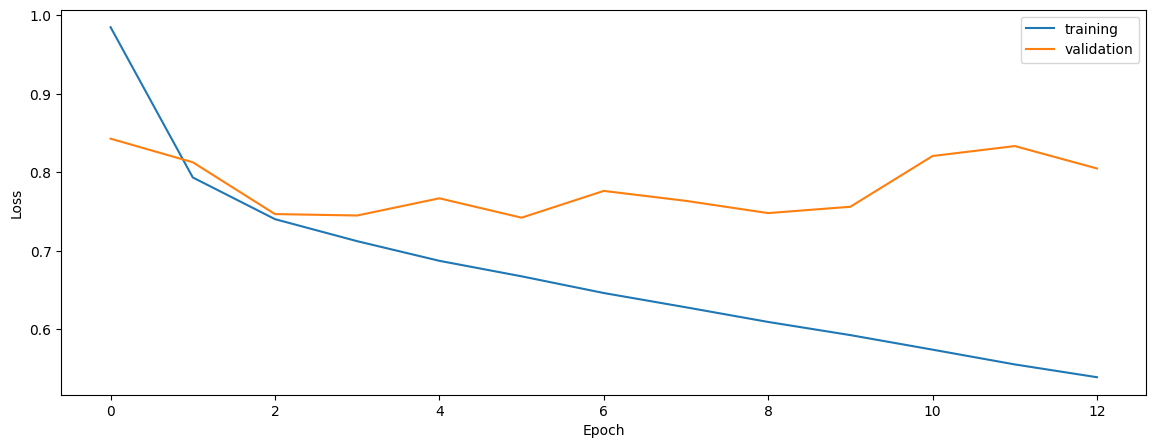

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7674871019601541
0.7408235038411062
0.7596649928204378


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7674871019601541
0.7408235038411062
0.7596649928204378


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7662851922550539
0.7531515846487192
0.7582335102090401


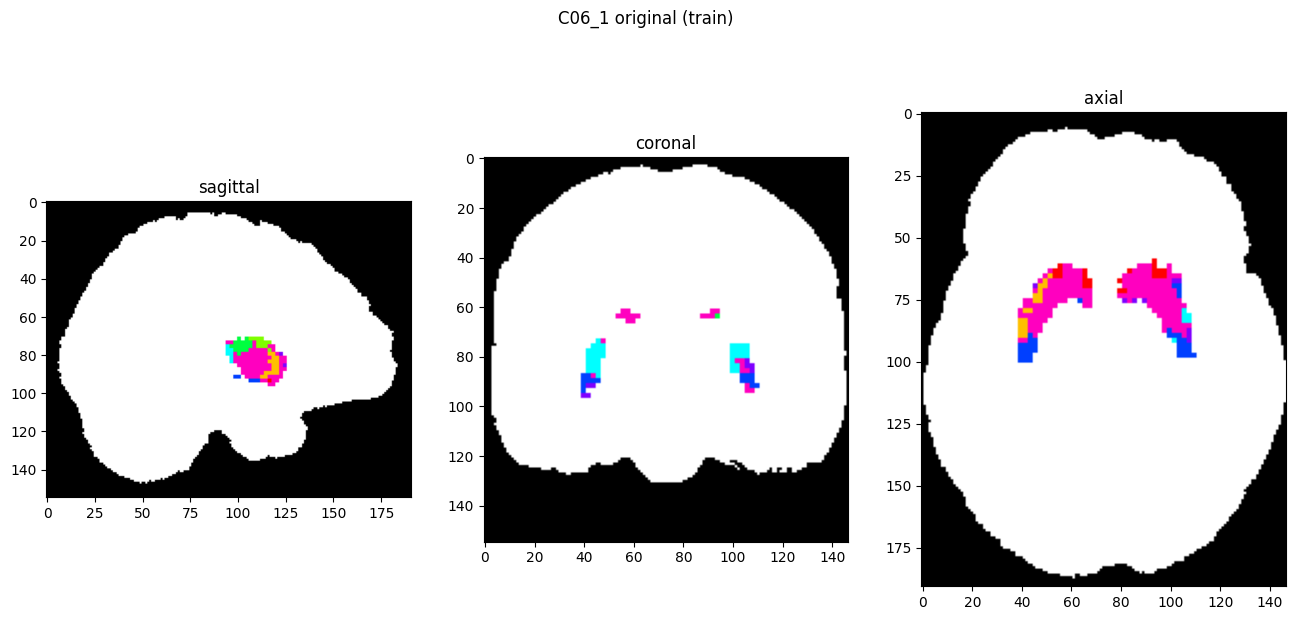

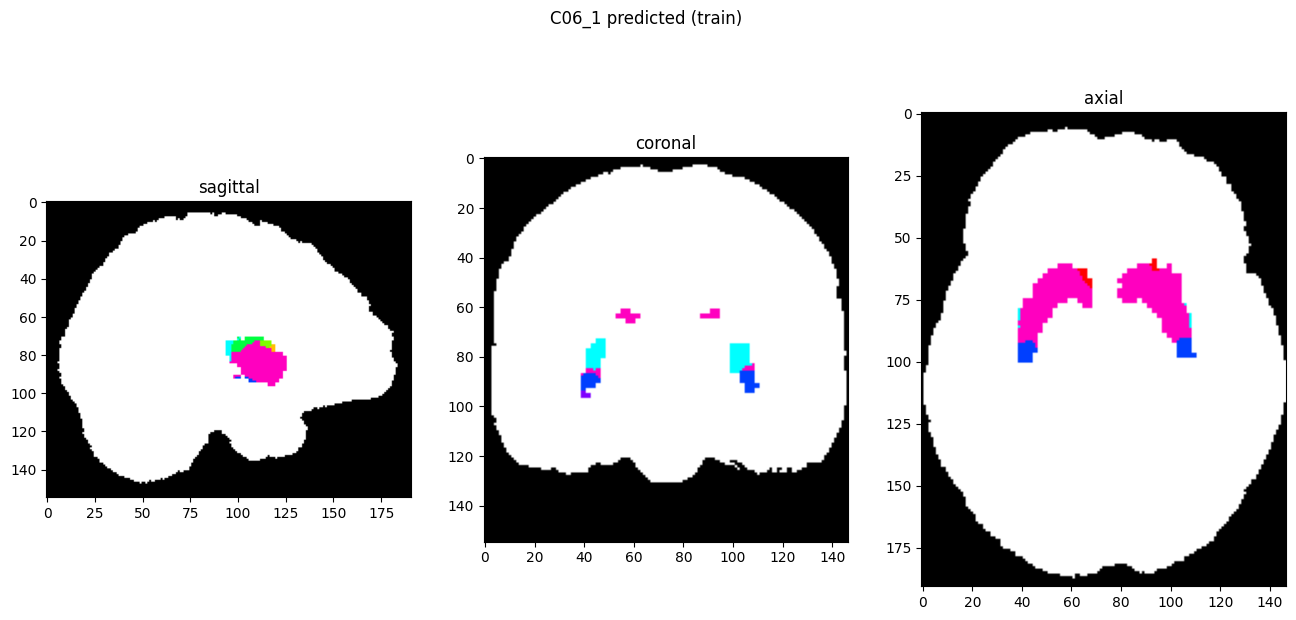

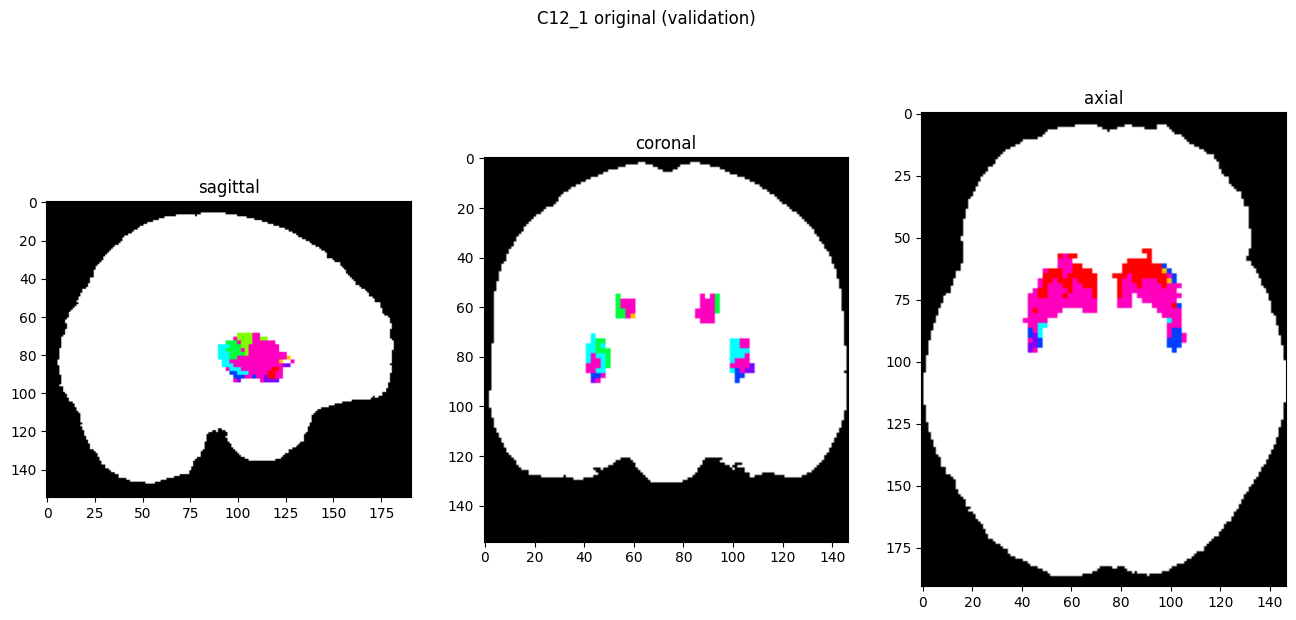

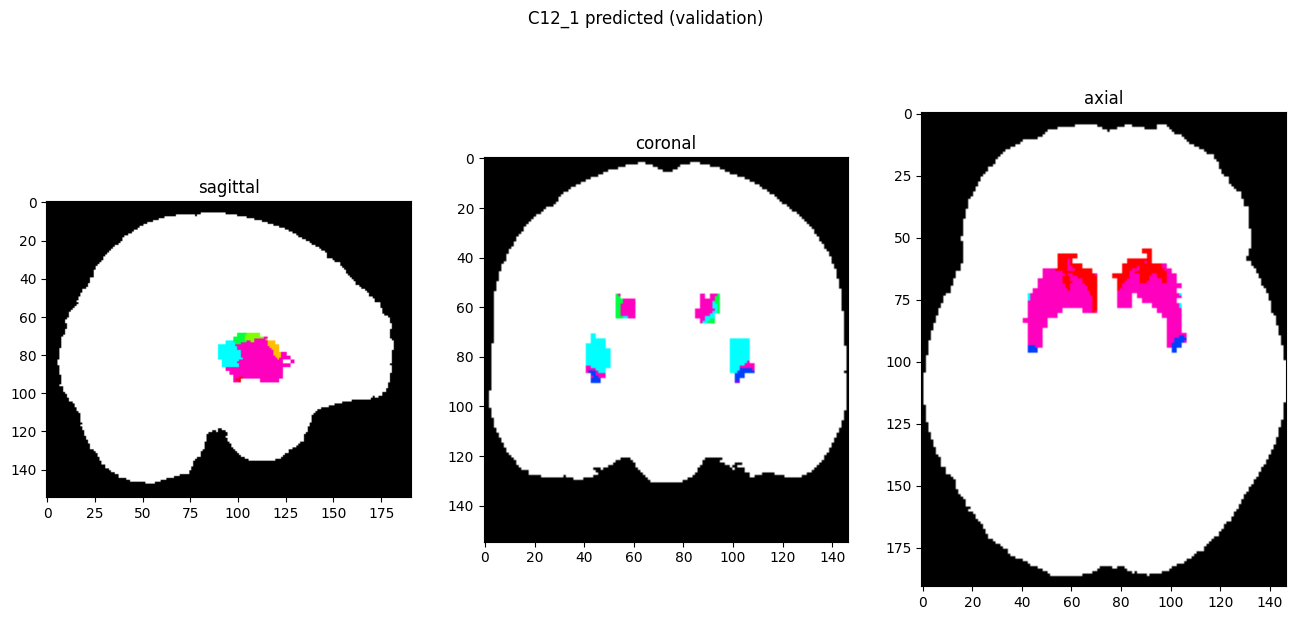

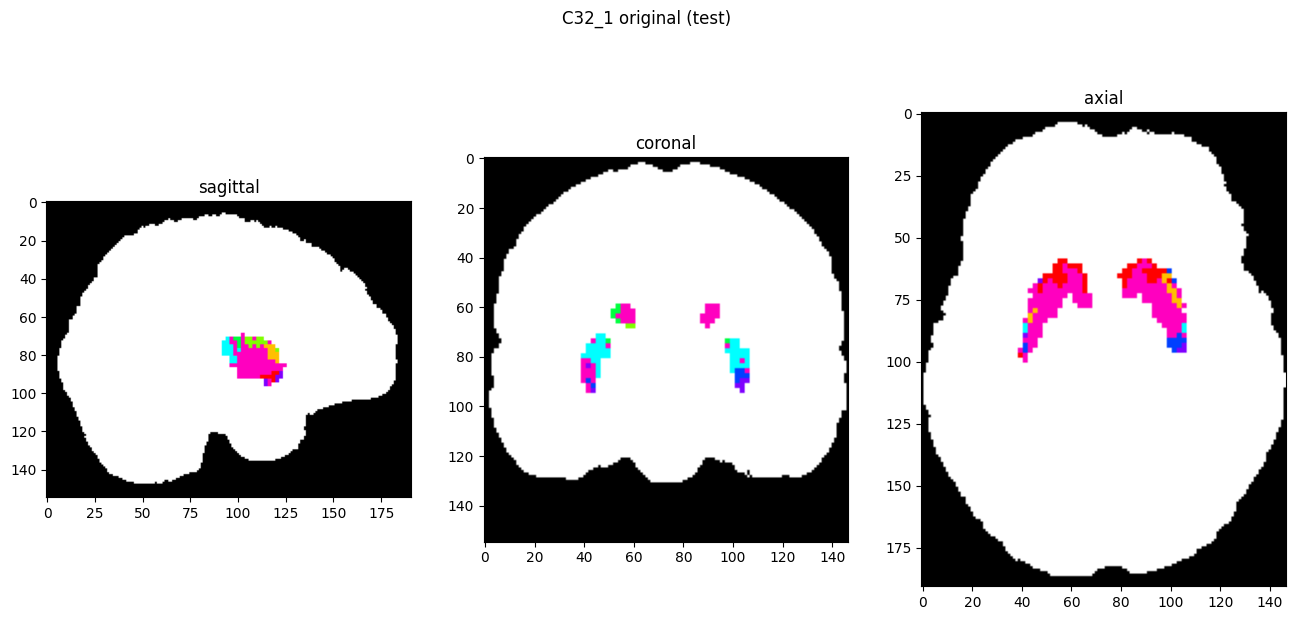

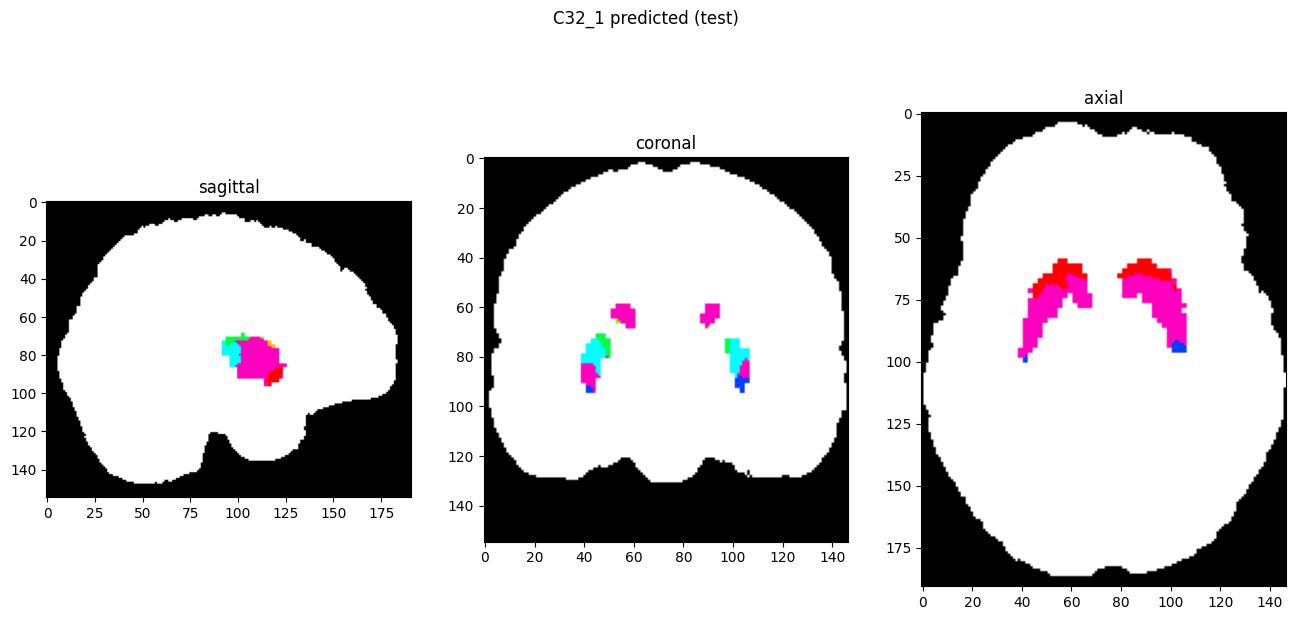

In [10]:
showResults(model, gen, threshold=0)